# velox instances

In [1]:
import dimod
import numpy
import os
import json
from dimod.serialization import coo

from dwave.system import DWaveSampler
import minorminer as mm
from dwave.embedding import embed_bqm
import pandas as pd

qpu = DWaveSampler(solver="Advantage_system6.4")
qpu_graph = qpu.to_networkx_graph()

path_to_ocean_instances = "../data/instances/pruned/1"
path_to_velox_instances = "../velox/instances/pruned/1"
instance_list = os.listdir(path_to_ocean_instances)
instance_list = sorted(instance_list, key=lambda x: (int(x.split("_")[1]), int(x[:-5].split("_")[3])))
print("Number of instances: ", len(instance_list))
print(instance_list)
  

Number of instances:  12
['precision_2_timepoints_3.json', 'precision_2_timepoints_4.json', 'precision_2_timepoints_5.json', 'precision_2_timepoints_6.json', 'precision_3_timepoints_3.json', 'precision_3_timepoints_4.json', 'precision_3_timepoints_5.json', 'precision_3_timepoints_6.json', 'precision_4_timepoints_3.json', 'precision_4_timepoints_4.json', 'precision_4_timepoints_5.json', 'precision_4_timepoints_6.json']


In [2]:
import dimod.serialization

energies = []

for instance in instance_list:
  old_path = os.path.join(path_to_ocean_instances, instance)
  with open(old_path, 'r') as f:
    bqm = dimod.BinaryQuadraticModel.from_serializable(json.load(f))
  num_interactions = len(bqm.quadratic)
  num_variables = len(bqm.variables)
  density = num_interactions / (num_variables * (num_variables - 1) / 2)
  print(f"Density of instance {instance}: {density}")

  var_map = {i:i+1 for i in range(num_variables)}
  bqm.relabel_variables(var_map)
  bqm.change_vartype(dimod.SPIN, inplace=True)
  print(bqm.offset)
  energies.append(-bqm.offset)
  new_path = os.path.join(path_to_velox_instances, instance.replace(".json", ".coo"))
  with open(new_path, 'w') as f:
    f.write(f"# E0 = {-bqm.offset}\n")
    coo.dump(bqm, f)

  embedding_path = os.path.join(path_to_velox_instances, instance.replace(".json", "_embedding.json"))
  if os.path.exists(embedding_path):
    with open(embedding_path, 'r') as ef:
      embedding = json.load(ef)
  else:
    embedding = mm.find_embedding(dimod.to_networkx_graph(bqm), qpu_graph)
    with open(embedding_path, 'w') as ef:
      json.dump(embedding, ef)
  bqm_embedded = embed_bqm(bqm, embedding, qpu_graph)
  bqm_embedded.relabel_variables_as_integers()
  new_var_map = {i:i+1 for i in range(len(bqm_embedded.variables))}
  bqm_embedded.relabel_variables(new_var_map)
  new_emb_path = os.path.join(path_to_velox_instances, instance.replace(".json", "_embedded.coo"))
  with open(new_emb_path, 'w') as f:
    f.write(f"# E0 = {-bqm_embedded.offset}\n")
    coo.dump(bqm_embedded, f)

Density of instance precision_2_timepoints_3.json: 0.21739130434782608
76.0


MissingChainError: chain for 1 is empty or not contained in this embedding

# unembedding 

In [ ]:

df = pd.read_csv('../velox/results/best_results_pruned_1_embedded.csv')

# Drop rows where num_steps is 1000000
df = df[df['num_steps'] < 1_000_000]

# Extract the two numbers from the instance names
pattern = r'precision_(\d)_timepoints_(\d)_embedded.coo'
df[['precision', 'timepoints']] = df['instance'].str.extract(pattern).astype(int)
df.head(10)

,instance,num_var,num_rep,num_steps,compress,runtime,gap,best_energy,gnd_energy,success_prob,best_solution,precision,timepoints
0,precision_2_timepoints_3_embedded.coo,32,65536,100,False,0.155775,-0.000008,-174.507553,-174.507539,0.453186,1;-1;-1;-1;1;-1;1;-1;1;-1;1;1;-1;-1;1;1;1;-1;-...,2,3
1,precision_2_timepoints_4_embedded.coo,46,65536,100,False,0.137468,-0.000015,-300.327545,-300.327499,0.041199,1;1;-1;-1;-1;1;-1;1;1;-1;1;-1;-1;1;-1;-1;1;1;-...,2,4
2,precision_2_timepoints_5_embedded.coo,60,65536,100,False,0.167733,0.000011,-430.173431,-430.173479,0.001526,1;-1;-1;1;-1;1;-1;1;-1;-1;1;1;-1;1;1;1;-1;-1;-...,2,5
3,precision_2_timepoints_6_embedded.coo,70,65536,100,False,0.188816,0.198867,-501.839142,-502.839124,0.000000,1;-1;-1;1;1;-1;-1;1;-1;-1;-1;-1;1;1;-1;-1;-1;1...,2,6
4,precision_3_timepoints_3_embedded.coo,62,65536,100,False,0.169423,-0.018689,-374.410645,-374.340682,0.004578,1;1;-1;-1;1;1;-1;-1;1;-1;-1;-1;1;-1;-1;-1;-1;-...,3,3
5,precision_3_timepoints_4_embedded.coo,86,65536,100,False,0.231866,-0.073530,-587.702637,-587.270814,0.003052,1;1;-1;1;1;-1;-1;-1;1;-1;-1;-1;-1;-1;-1;1;1;1;...,3,4
6,precision_3_timepoints_5_embedded.coo,119,65536,100,False,0.318218,-0.567610,-920.671997,-915.475667,0.091553,-1;-1;1;1;-1;-1;-1;1;1;-1;-1;-1;-1;-1;-1;-1;-1...,3,5
7,precision_3_timepoints_6_embedded.coo,139,65536,100,False,0.399526,-0.332865,-1086.835449,-1083.229755,0.019836,1;-1;-1;-1;-1;-1;-1;1;-1;-1;1;1;-1;-1;-1;-1;1;...,3,6
8,precision_4_timepoints_3_embedded.coo,97,65536,100,False,0.273220,-3.140128,-588.201172,-570.293234,1.579285,-1;-1;-1;-1;-1;-1;1;1;-1;1;1;1;-1;-1;1;1;-1;-1...,4,3
9,precision_4_timepoints_4_embedded.coo,148,65536,100,False,0.397062,-0.925988,-1040.775635,-1031.226597,0.518799,-1;-1;-1;1;1;1;1;1;1;1;-1;-1;-1;1;1;-1;-1;-1;-...,4,4


In [ ]:
from dwave.embedding import unembed_sampleset

# Group the dataframe by precision and timepoints.
# For each group, pick the row with the best (lowest) best_energy,
# then load the corresponding original bqm from file (from the ocean instances),
# recompute its embedding, and unembed the best solution.

for (prec, timep), group in df.groupby(['precision', 'timepoints']):
  # Select the best sample in the group (lowest best_energy)
  for row in group.itertuples():
    # Construct the original instance filename (without the "_embedded" suffix)
    original_filename = f"precision_{prec}_timepoints_{timep}.json"
    original_file_path = os.path.join(path_to_ocean_instances, original_filename)
  
    # Load the original bqm
    with open(original_file_path, 'r') as f:
      original_bqm = dimod.BinaryQuadraticModel.from_serializable(json.load(f))
  
    # Apply the same relabeling and vartype conversion as before
    num_variables = len(original_bqm.variables)
    var_map = {i: i + 1 for i in range(num_variables)}
    original_bqm.relabel_variables(var_map)
    original_bqm.change_vartype(dimod.SPIN, inplace=True)
  
    # Compute the embedding of the original bqm onto the QPU graph
    path_to_embedding = os.path.join(path_to_velox_instances, original_filename.replace(".json", "_embedding.json"))
    with open(path_to_embedding, 'r') as ef:
      embedding = json.load(ef)
      embedding = {int(k): [int(v) for v in vs] for k, vs in embedding.items()}
  
    embedded_bqm = embed_bqm(original_bqm, embedding, qpu_graph)
    _,tmp_emb = embedded_bqm.relabel_variables_as_integers()
    new_var_map = {i: i + 1 for i in range(len(embedded_bqm.variables))}
    inv_tmp_emb = {v: k for k, v in tmp_emb.items()}
    embedded_bqm.relabel_variables(new_var_map)

    energy = row[8] + embedded_bqm.offset

    # Load the embedding from the file
    # It assumes the sample is encoded as values separated by semicolons
    sample_values = list(map(int, row[-3].split(';')))
    # The variable keys correspond to 1,2,..., len(sample_values)
    sample_dict = {i + 1: val for i, val in enumerate(sample_values)}

    tmp_sample_dict = {k-1: v for k, v in sample_dict.items()}
    tmp_sample_dict = {tmp_emb[k]: v for k, v in tmp_sample_dict.items()}
    recomputed_energy = embedded_bqm.energy(sample_dict)

    # # Create a SampleSet from the sample dictionary
    sampleset = dimod.SampleSet.from_samples([tmp_sample_dict], vartype=dimod.SPIN, energy=recomputed_energy)
  
    # # Unembed the sample back to the original variable space
    unembedded = unembed_sampleset(sampleset, embedding, original_bqm, chain_break_fraction=True)

    unembedded_energy = unembedded.first.energy - original_bqm.offset
    ground_energy = -original_bqm.offset
    gap = (unembedded_energy - ground_energy) / abs(ground_energy) * 100

    df.at[row.Index, 'unembedded_energy'] = unembedded_energy
    df.at[row.Index, 'unembedded_gap'] = gap
    df.at[row.Index, 'unembedded_sample'] = str(unembedded.first.sample)
  

In [ ]:
df.to_csv('../velox/results/best_results_pruned_1_unembedded.csv', index=False)

# Dynamics from Velox

In [ ]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective # Difference a. We are using ComplexDynamics
import dimod
import matplotlib.pyplot as plt
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

prec = 3
timepoints = 6


# The problem object encapsulates all the data so you don't have to pass them around
problem = ComplexDynamicsProblem(
    hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
    initial_state = PSI0,              # Starting at initial state |0>,
    times=tuple(range(timepoints)),             # With six time points 0,1,2
    num_bits_per_var=prec               # And two bits of precision per variable
)

qubo = problem.qubo(objective=Objective.norm)
num_int = qubo.num_interactions + 1
while (num_int > qubo.num_interactions):
    num_int = qubo.num_interactions
    for key,value in qubo.quadratic.items():
        if value == 0:
            qubo.remove_interaction(key[0],key[1])

In [ ]:
velox_results = pd.read_csv('../velox/results/best_results_pruned_1_native.csv')
pattern = r'precision_(\d)_timepoints_(\d)'
velox_results = velox_results[velox_results["num_steps"] < 1000000]
velox_results.sort_values(by=['num_steps', 'num_rep'], inplace=True)
velox_results[['precision', 'timepoints']] = velox_results['instance'].str.extract(pattern).astype(int)
velox_results = velox_results[velox_results['precision'] == prec]
velox_results = velox_results[velox_results['timepoints'] == timepoints]
velox_results


,instance,num_var,num_rep,num_steps,compress,runtime,gap,best_energy,gnd_energy,success_prob,best_solution,precision,timepoints
7,precision_3_timepoints_6.coo,72,8,100,False,0.002441,3.504673,-206.50,-214.0,0.0,-1;1;-1;-1;1;-1;-1;1;-1;-1;1;-1;-1;1;-1;-1;-1;...,3,6
55,precision_3_timepoints_6.coo,72,16,100,False,0.002553,3.154206,-207.25,-214.0,0.0,-1;1;1;-1;1;-1;-1;1;1;-1;-1;1;-1;-1;1;-1;1;1;-...,3,6
103,precision_3_timepoints_6.coo,72,32,100,False,0.004275,1.869159,-210.00,-214.0,0.0,1;-1;-1;-1;1;-1;1;-1;-1;-1;1;-1;-1;-1;-1;-1;1;...,3,6
151,precision_3_timepoints_6.coo,72,64,100,False,0.004103,1.985981,-209.75,-214.0,0.0,-1;1;-1;-1;1;1;-1;1;1;-1;-1;1;-1;-1;1;1;-1;-1;...,3,6
199,precision_3_timepoints_6.coo,72,128,100,False,0.005810,1.285047,-211.25,-214.0,0.0,-1;1;1;-1;1;1;-1;-1;1;-1;1;-1;-1;1;1;-1;1;-1;-...,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,precision_3_timepoints_6.coo,72,16384,100000,False,46.372113,0.233645,-213.50,-214.0,0.0,1;-1;-1;-1;1;-1;-1;1;1;-1;1;1;-1;-1;-1;-1;-1;-...,3,6
607,precision_3_timepoints_6.coo,72,32768,100000,False,90.954232,0.116822,-213.75,-214.0,0.0,1;-1;-1;-1;1;-1;-1;1;-1;-1;1;1;-1;1;-1;-1;-1;-...,3,6
823,precision_3_timepoints_6.coo,72,65536,100000,False,179.640289,0.116822,-213.75,-214.0,0.0,1;-1;-1;-1;-1;1;-1;1;-1;-1;1;-1;-1;1;-1;-1;1;-...,3,6
871,precision_3_timepoints_6.coo,72,131072,100000,False,359.328543,0.116822,-213.75,-214.0,0.0,1;-1;-1;-1;1;-1;-1;1;1;-1;1;-1;-1;-1;-1;-1;1;-...,3,6


In [ ]:
import qutip as qp
H_qp = 0.5 * np.pi * qp.sigmay()
psi_0 = qp.basis(2, 0)
times = np.linspace(0, timepoints-1, 100)
baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.sigmaz()]).expect[0]

Energy: 0.0
QUBO energy:  0.0
[np.float64(1.0), np.float64(-1.0), np.float64(1.0), np.float64(-1.0), np.float64(1.0), np.float64(-1.0)]
Energy: 0.116822429906542
QUBO energy:  0.25
[np.float64(0.25), np.float64(0.0), np.float64(0.25), np.float64(-0.25), np.float64(0.25), np.float64(-0.25)]
Energy: 0.233644859813084
QUBO energy:  0.5
[np.float64(0.0), np.float64(0.25), np.float64(-0.25), np.float64(0.25), np.float64(-0.25), np.float64(0.25)]
Energy: 0.3504672897196261
QUBO energy:  0.75
[np.float64(0.75), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
Energy: 0.4672897196261681
QUBO energy:  1.0
[np.float64(1.0), np.float64(-1.0), np.float64(1.0), np.float64(-1.0), np.float64(1.0), np.float64(-1.0)]


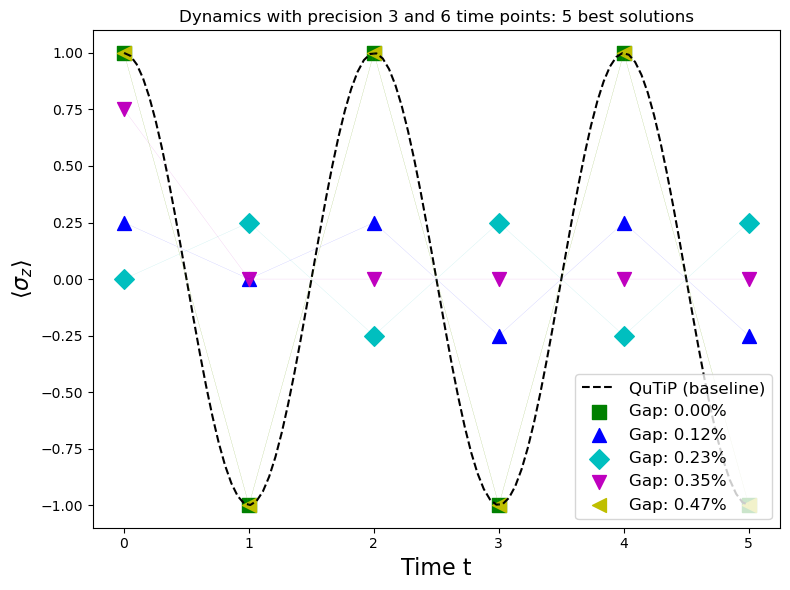

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

SZ = np.array([[1, 0], [0, -1]])

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Compute normalization parameters for the energy values of all solutions

# Create a single axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(times, baseline, "k--", label="QuTiP (baseline)")

velox_results.sort_values(by=['gap'], inplace=True)
energy_vals = velox_results['gap'].values
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.viridis


# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

cnt = 0
existing_energies = []
for idx, row in velox_results.iterrows():
  sol = row['best_solution']
  sol_list = [0 if x.strip() == "-1" else 1 for x in sol.split(';')]
  sol_dict = {i: sol_list[i] for i in range(len(sol_list))}
  # Compute the dynamics using the problem's interpretation method.
  vec = problem.interpret_sample(sol_dict)
  # For each state in the trajectory, compute ⟨σ_z⟩.
  expect = [(state.conj() @ SZ @ state).real for state in vec]
  energy = row['gap']
  if energy in existing_energies:
    continue
  existing_energies.append(energy)
  cnt += 1
  print(f"Energy: {energy}")
  print("QUBO energy: ", qubo.energy(sol_dict))
  ax.scatter(problem.times, expect, color=colors[cnt % len(colors)], marker=markers[cnt % len(markers)], label=f"Gap: {energy:.2f}%", alpha=1.0, s=100)
  ax.plot(problem.times, expect, color=colors[cnt % len(colors)], alpha=0.5, linewidth=0.1)
  print(expect)
  if cnt == 5:
    break

ax.set_xlabel("Time t", fontsize=16)
ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=16)
ax.set_title(f"Dynamics with precision {problem.num_bits_per_var} and {len(problem.times)} time points: {len(existing_energies)} best solutions")


plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.savefig(f"../velox/results/dynamics_plots/precision_{problem.num_bits_per_var}_timepoints_{len(problem.times)}.pdf", dpi=300)
plt.show()


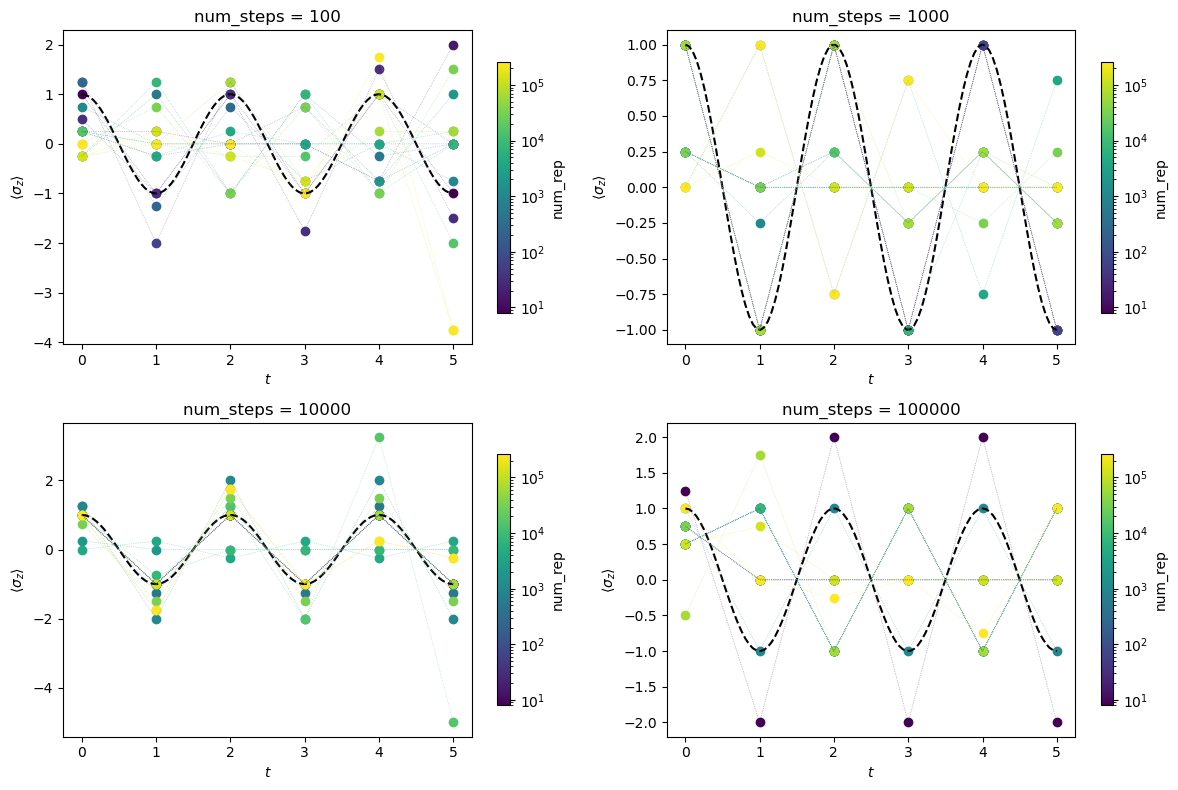

In [315]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

SZ = np.array([[1, 0], [0, -1]])

# Get unique num_steps values and sort them (expecting 4 unique values)
num_steps_vals = sorted(velox_results['num_steps'].unique())

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Dictionary to hold extracted BQM-compatible solution dicts for each panel
solutions_dict = {}

for ax, ns in zip(axs.flatten(), num_steps_vals):
    # Filter results for the current num_steps value
    sub_df = velox_results[velox_results['num_steps'] == ns]
    # Plot the qutip baseline (here as a horizontal red line)
    ax.plot(times, baseline, "k--", label="QuTiP (baseline)")
    
    # Extract a solution row from the dataframe.
    # Assumes a column 'solution' exists containing a comma-separated string of bits, e.g. "0,1,0,1"
    if 'best_solution' in sub_df.columns and not sub_df.empty:
      num_rep_vals = sub_df['num_rep'].unique()
      colors = plt.cm.viridis(np.linspace(0, 1, len(num_rep_vals)))
      for k, num_rep in enumerate(num_rep_vals):
        sol = sub_df[sub_df['num_rep'] == num_rep]['best_solution'].values[0]
        sol_list = [0 if x == "-1" else 1 for x in sol.split(';')]
        sol_dict = {i: sol_list[i] for i in range(len(sol_list))}
        vec = problem.interpret_sample(sol_dict)
        expect = [(state.conj() @ SZ @ state).real for state in vec]
        ax.scatter(problem.times, expect, label=f"num_rep = {num_rep}", alpha=1.0, color=colors[k])
        ax.plot(problem.times, expect, label=f"num_rep = {num_rep}", alpha=0.5, color=colors[k], linestyle=':', linewidth=0.5)


    # The scatter plot doesn't directly support a colorbar for 'num_rep', so we'll create a ScalarMappable
    # to associate the colors with the 'num_rep' values.
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from matplotlib.colors import LogNorm
    norm = LogNorm(vmin=min(num_rep_vals), vmax=max(num_rep_vals))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])  # You have to set a dummy array for ScalarMappable to work

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label('num_rep')
    
    ax.set_title(f'num_steps = {ns}')
    ax.set_ylabel(r"$\langle \sigma_z \rangle$")
    ax.set_xlabel("$t$")

plt.tight_layout()
plt.show()
